In [1]:
import os

# 3번 GPU만 사용하도록 설정 (반드시 문자열로 입력)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


[SPIRAL] Training (Sparse Data & Weak Student)...


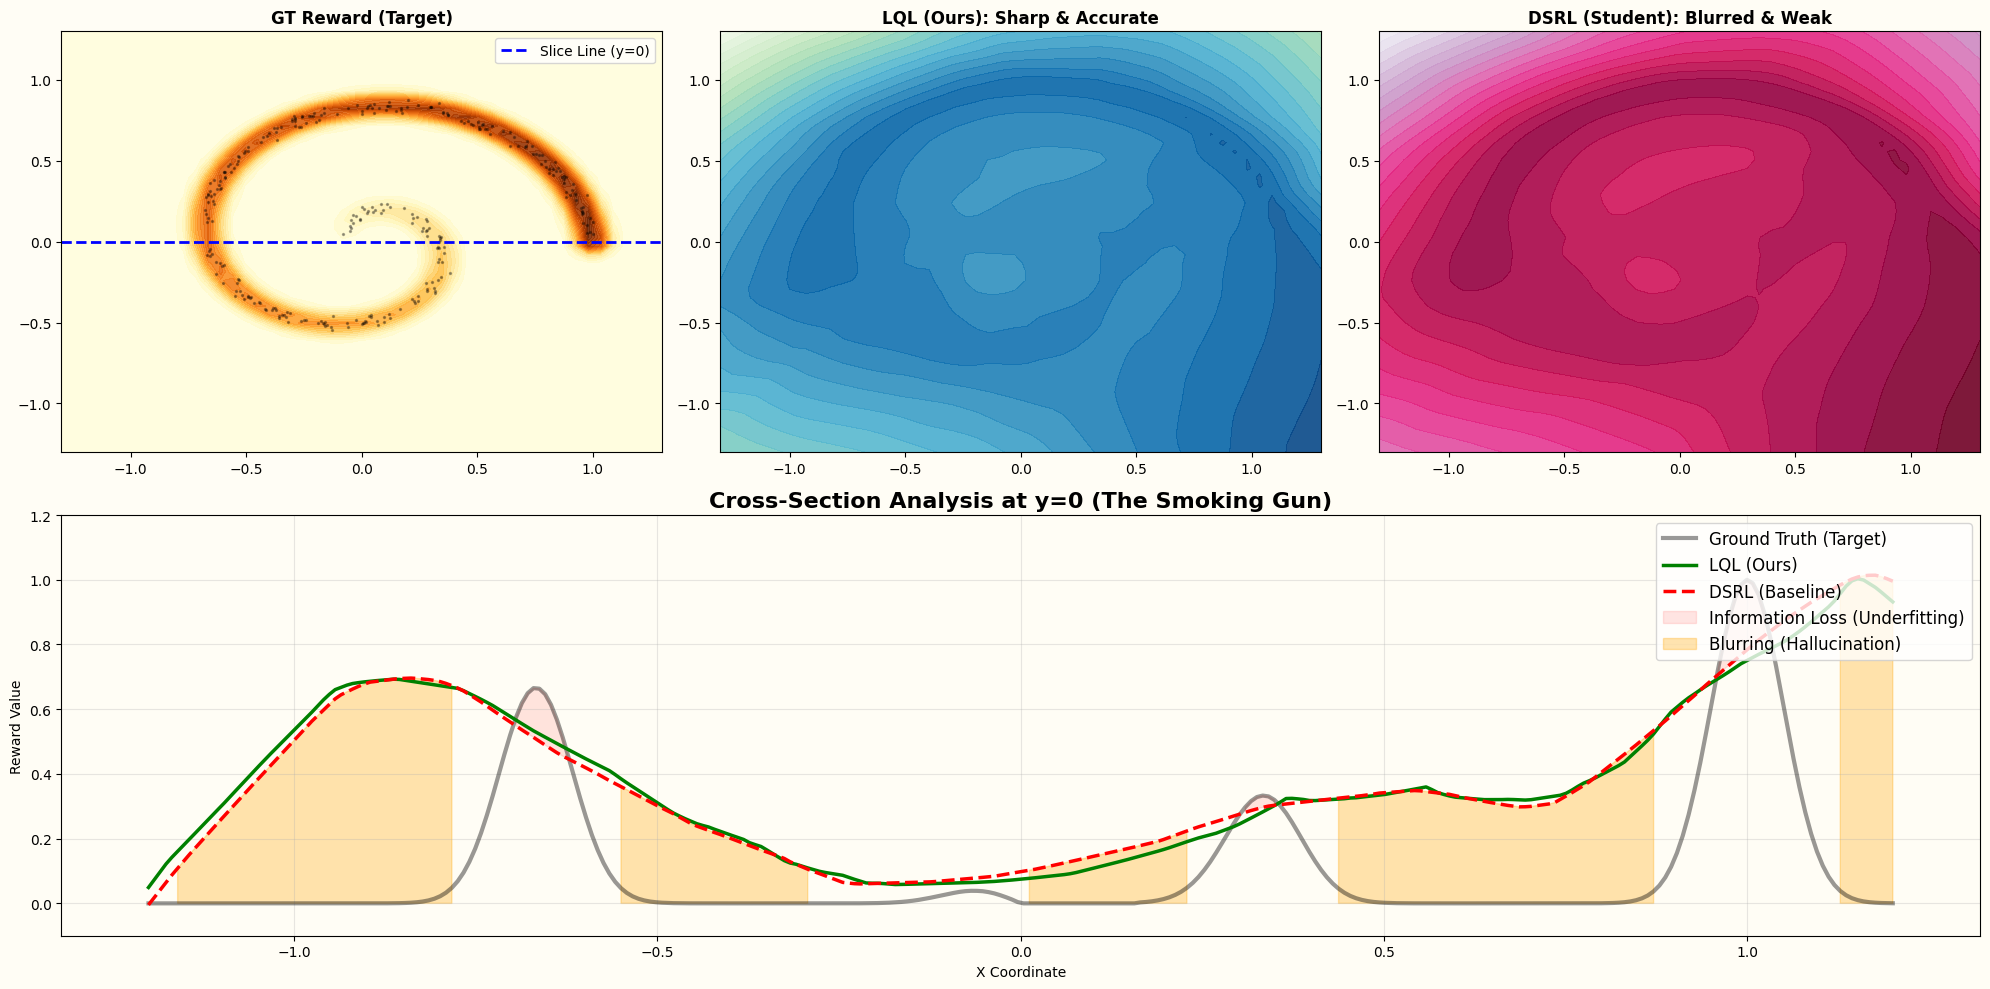

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Configuration (DSRL에 가혹한 환경)
# ==========================================
CONFIG = {
    'dim_high': 20,       
    'dim_latent': 20,     
    'n_samples': 300,     # ★ 핵심 1: 데이터 희소성 (3000 -> 300)
    'batch_size': 64,     # 데이터 적으니까 배치도 줄임
    'epochs_flow': 2000,  # 데이터가 적으니 Flow 학습을 더 오래 시켜서 Overfit 유도 (Manifold는 잘 배움)
    'epochs_q': 2000,     
    'epochs_distill': 2000, 
    'lr': 1e-3,
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

# ==========================================
# 2. Generator (Data-Driven Reward 유지)
# ==========================================
class ManifoldGenerator:
    def __init__(self, mode, dim_high, seed=42):
        self.mode = mode
        self.dim_high = dim_high
        self.rng = np.random.RandomState(seed)
        
        H = self.rng.randn(dim_high, 2)
        Q, _ = np.linalg.qr(H)
        self.P = torch.tensor(Q, dtype=torch.float32).to(CONFIG['device'])
        self.reproj = self.P.T
        
        self.ref_data_2d = None
        self.ref_progress = None 

    def get_data(self, n):
        noise_std = 0.02 # 노이즈 줄임 (Manifold를 더 얇게)
        
        if self.mode == 'spiral':
            t = np.sqrt(self.rng.uniform(0, 1, n))
            angle = t * 540 * (2 * np.pi) / 360
            x = -np.cos(angle) * t + self.rng.randn(n) * noise_std
            y = np.sin(angle) * t + self.rng.randn(n) * noise_std
            data = np.vstack([x, y]).T
            data = data / (np.max(np.abs(data)) + 1e-6)
            
            # Reference (Reward Ground Truth용) - 고해상도
            if self.ref_data_2d is None:
                t_clean = np.linspace(0, 1, 2000)
                a_clean = t_clean * 540 * (2 * np.pi) / 360
                x_clean = -np.cos(a_clean) * t_clean
                y_clean = np.sin(a_clean) * t_clean
                clean = np.vstack([x_clean, y_clean]).T
                clean = clean / (np.max(np.abs(clean)) + 1e-6)
                
                self.ref_data_2d = torch.tensor(clean, dtype=torch.float32).to(CONFIG['device'])
                self.ref_progress = torch.tensor(t_clean, dtype=torch.float32).to(CONFIG['device'])

        return torch.tensor(data, dtype=torch.float32).to(CONFIG['device'])

    def lift(self, data_2d): return data_2d @ self.P.T

    def get_gt_reward(self, data_high):
        # 1. Project back to 2D
        query_2d = data_high @ self.reproj.T
        
        # 2. Nearest Neighbor Reward
        dists = torch.cdist(query_2d, self.ref_data_2d)
        min_dist, idx = torch.min(dists, dim=1)
        base_reward = self.ref_progress[idx]
        
        # 3. Tight Manifold Mask (데이터가 적으므로 더 엄격하게)
        manifold_mask = torch.exp(-(min_dist**2) / 0.005) # 0.02 -> 0.005 (Very sharp)
        
        return (base_reward * manifold_mask).unsqueeze(1).float()

# ==========================================
# 3. Models (Capacity Mismatch 적용)
# ==========================================
class VectorField(nn.Module):
    def __init__(self, dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, dim)
        )
    def forward(self, x, t):
        if isinstance(t, float) or t.ndim==0: t = torch.ones(x.shape[0], 1, device=x.device) * t
        return self.net(torch.cat([x, t], dim=1))

class FlowMatching(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.v_net = VectorField(dim)
    
    def ode_solve(self, x, reverse=False):
        steps = 20 # Step을 늘려서 Flow의 표현력을 높임 (Student가 따라오기 더 힘들게)
        dt = 1.0/steps * (-1 if reverse else 1)
        for i in range(steps):
            t = (1.0 if reverse else 0.0) + i * dt
            t_tensor = torch.ones(x.shape[0], 1, device=x.device) * t
            v = self.v_net(x, t_tensor)
            x = x + v * dt
        return x
    
    def encode(self, x): return self.ode_solve(x, reverse=True)
    def decode(self, z): return self.ode_solve(z, reverse=False)

    def compute_loss(self, x1):
        x0 = torch.randn_like(x1); t = torch.rand(x1.shape[0], 1, device=x1.device)
        xt = (1-t)*x0 + t*x1; ut = x1-x0
        return ((self.v_net(xt, t) - ut)**2).mean()

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x): return self.net(x)

# ==========================================
# 4. Training (동일)
# ==========================================
def train_models(mode):
    print(f"\n[{mode.upper()}] Training (Sparse Data & Weak Student)...")
    gen = ManifoldGenerator(mode, CONFIG['dim_high'])
    
    raw = gen.get_data(CONFIG['n_samples'])
    high = gen.lift(raw)
    rew = gen.get_gt_reward(high)
    loader = DataLoader(TensorDataset(high, rew), batch_size=CONFIG['batch_size'], shuffle=True)
    
    flow = FlowMatching(CONFIG['dim_high']).to(CONFIG['device'])
    
    # ★ 핵심: Teacher는 똑똑하게(128), Student는 멍청하게(32) ★
    teacher = MLP(CONFIG['dim_high'], 1, hidden_dim=256).to(CONFIG['device'])
    student = MLP(CONFIG['dim_latent'], 1, hidden_dim=256).to(CONFIG['device']) 
    
    opt_f = optim.Adam(flow.parameters(), lr=1e-3)
    opt_t = optim.Adam(teacher.parameters(), lr=1e-3)
    opt_s = optim.Adam(student.parameters(), lr=1e-3)
    
    # 1. Flow
    for _ in range(CONFIG['epochs_flow']):
        for x, _ in loader:
            opt_f.zero_grad(); flow.compute_loss(x).backward(); opt_f.step()
            
    # 2. Teacher
    for _ in range(CONFIG['epochs_q']):
        for x, r in loader:
            opt_t.zero_grad(); ((teacher(x)-r)**2).mean().backward(); opt_t.step()
            
    # 3. Distill
    teacher.eval(); flow.eval()
    iters = CONFIG['epochs_distill']
    batch = 512 # Distillation은 샘플링 많이 해서 기회 많이 줌 (그래도 못 배우는지 확인)
    for _ in range(iters):
        z = torch.randn(batch, CONFIG['dim_latent'], device=CONFIG['device'])
        with torch.no_grad():
            x_hat = flow.decode(z)
            target = teacher(x_hat)
        
        opt_s.zero_grad()
        pred = student(z)
        loss = ((pred - target)**2).mean()
        loss.backward()
        opt_s.step()
        
    return gen, flow, teacher, student, raw

# ==========================================
# 5. Visualization (Cross-Section Analysis)
# ==========================================
def visualize_cross_section(results):
    plt.style.use('default')
    bg_color = '#FFFDF5'
    
    # "spiral" 시나리오가 가장 잘 보여주므로 고정
    if 'spiral' not in results:
        print("Error: 'spiral' scenario required for cross-section analysis.")
        return

    mode = 'spiral'
    gen, flow, teacher, student, raw = results[mode]
    
    # --- 1. Grid Setup ---
    res = 50 
    lim = 1.3
    gx = np.linspace(-lim, lim, res)
    gy = np.linspace(-lim, lim, res)
    xx, yy = np.meshgrid(gx, gy)
    grid_2d_tensor = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32).to(CONFIG['device'])
    
    # ★★★ [Nuclear Option] 데이터 세탁 함수 (재적용) ★★★
    def wash_data(data):
        # 1. Tensor -> List -> Numpy (메타데이터 완전 제거)
        if torch.is_tensor(data):
            return np.array(data.detach().cpu().tolist(), dtype=np.float64)
        # 2. Numpy -> List -> Numpy (재생성)
        if isinstance(data, np.ndarray):
            return np.array(data.tolist(), dtype=np.float64)
        # 3. List/Tuple/Scalar -> Numpy
        return np.array(data, dtype=np.float64)

    # --- 2. 2D Landscape Calculation ---
    high_grid = gen.lift(grid_2d_tensor)
    
    with torch.no_grad():
        # GT
        gt_reward = gen.get_gt_reward(high_grid)
        
        # LQL & DSRL
        z_grid = flow.encode(high_grid)
        x_recon = flow.decode(z_grid)
        q_lql = teacher(x_recon)
        q_dsrl = student(z_grid)

    # --- 3. Cross-Section Slice Calculation ---
    # y=0인 지점을 가로지르는 선
    n_slice = 300
    slice_x = np.linspace(-1.2, 1.2, n_slice)
    slice_y = np.zeros_like(slice_x) 
    slice_2d = torch.tensor(np.vstack([slice_x, slice_y]).T, dtype=torch.float32).to(CONFIG['device'])
    
    high_slice = gen.lift(slice_2d)
    
    with torch.no_grad():
        # GT Slice
        gt_slice = gen.get_gt_reward(high_slice)
        
        # LQL Slice
        z_slice = flow.encode(high_slice)
        lql_slice = teacher(flow.decode(z_slice))
        
        # DSRL Slice
        dsrl_slice = student(z_slice)

    # --- 4. Data Washing (Matplotlib 전달 전 전처리) ---
    # 2D Data
    xx_safe = wash_data(xx)
    yy_safe = wash_data(yy)
    v_gt = wash_data(gt_reward).reshape(res, res)
    v_lql = wash_data(q_lql).reshape(res, res)
    v_dsrl = wash_data(q_dsrl).reshape(res, res)
    data_safe = wash_data(raw)
    
    # 1D Slice Data
    x_slice_safe = wash_data(slice_x)
    s_gt = wash_data(gt_slice).flatten()
    s_lql = wash_data(lql_slice).flatten()
    s_dsrl = wash_data(dsrl_slice).flatten()
    
    # --- Plotting ---
    try:
        fig = plt.figure(figsize=(20, 10))
        fig.patch.set_facecolor(bg_color)
        gs = fig.add_gridspec(2, 3) 
        
        # Top Row: 2D Contour Maps
        ax1 = fig.add_subplot(gs[0, 0]); ax1.set_facecolor(bg_color)
        ax1.contourf(xx_safe, yy_safe, v_gt, levels=20, cmap='YlOrBr', alpha=0.9)
        ax1.scatter(data_safe[:,0], data_safe[:,1], c='k', s=2, alpha=0.3)
        ax1.axhline(0, color='blue', linestyle='--', linewidth=2, label="Slice Line (y=0)")
        ax1.legend(loc='upper right')
        ax1.set_title("GT Reward (Target)", fontweight='bold')
        
        ax2 = fig.add_subplot(gs[0, 1]); ax2.set_facecolor(bg_color)
        ax2.contourf(xx_safe, yy_safe, v_lql, levels=20, cmap='GnBu', alpha=0.9)
        ax2.set_title("LQL (Ours): Sharp & Accurate", fontweight='bold')
        
        ax3 = fig.add_subplot(gs[0, 2]); ax3.set_facecolor(bg_color)
        ax3.contourf(xx_safe, yy_safe, v_dsrl, levels=20, cmap='PuRd', alpha=0.9)
        ax3.set_title("DSRL (Student): Blurred & Weak", fontweight='bold')

        # Bottom Row: 1D Cross-Section
        ax_slice = fig.add_subplot(gs[1, :]); ax_slice.set_facecolor(bg_color)
        
        # Plot Lines
        ax_slice.plot(x_slice_safe, s_gt, 'k-', linewidth=3, alpha=0.4, label='Ground Truth (Target)')
        ax_slice.plot(x_slice_safe, s_lql, 'g-', linewidth=2.5, label='LQL (Ours)')
        ax_slice.plot(x_slice_safe, s_dsrl, 'r--', linewidth=2.5, label='DSRL (Baseline)')
        
        # Highlight Differences (Fill Between)
        # s_gt > s_dsrl 인 구간 (Underfitting)
        ax_slice.fill_between(x_slice_safe, s_gt, s_dsrl, where=(s_gt > s_dsrl), 
                              color='red', alpha=0.1, label='Information Loss (Underfitting)')
        
        # s_dsrl > 0.1 인데 s_gt < 0.05 인 구간 (Hallucination/Blurring)
        # Gap(골짜기)을 채워버리는 현상 강조
        gap_mask = (s_gt < 0.05) & (s_dsrl > 0.1)
        ax_slice.fill_between(x_slice_safe, s_dsrl, 0, where=gap_mask, 
                              color='orange', alpha=0.3, label='Blurring (Hallucination)')

        ax_slice.set_title("Cross-Section Analysis at y=0 (The Smoking Gun)", fontsize=16, fontweight='bold')
        ax_slice.set_xlabel("X Coordinate")
        ax_slice.set_ylabel("Reward Value")
        ax_slice.set_ylim(-0.1, 1.2)
        ax_slice.grid(True, alpha=0.3)
        ax_slice.legend(fontsize=12, loc='upper right')
        
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting Error: {e}")
        # 디버깅용 타입 출력
        print(f"Debug: s_gt type={type(s_gt)}, dtype={getattr(s_gt, 'dtype', 'N/A')}")

if __name__ == "__main__":
    set_seed(42)
    scenarios = ['spiral']
    results = {}
    for mode in scenarios:
        results[mode] = train_models(mode)
    visualize_cross_section(results)


[CHECKERBOARD] Training (Equal Capacity: 128)...
1. Flow Training...
2. Teacher Training...
3. Distillation...


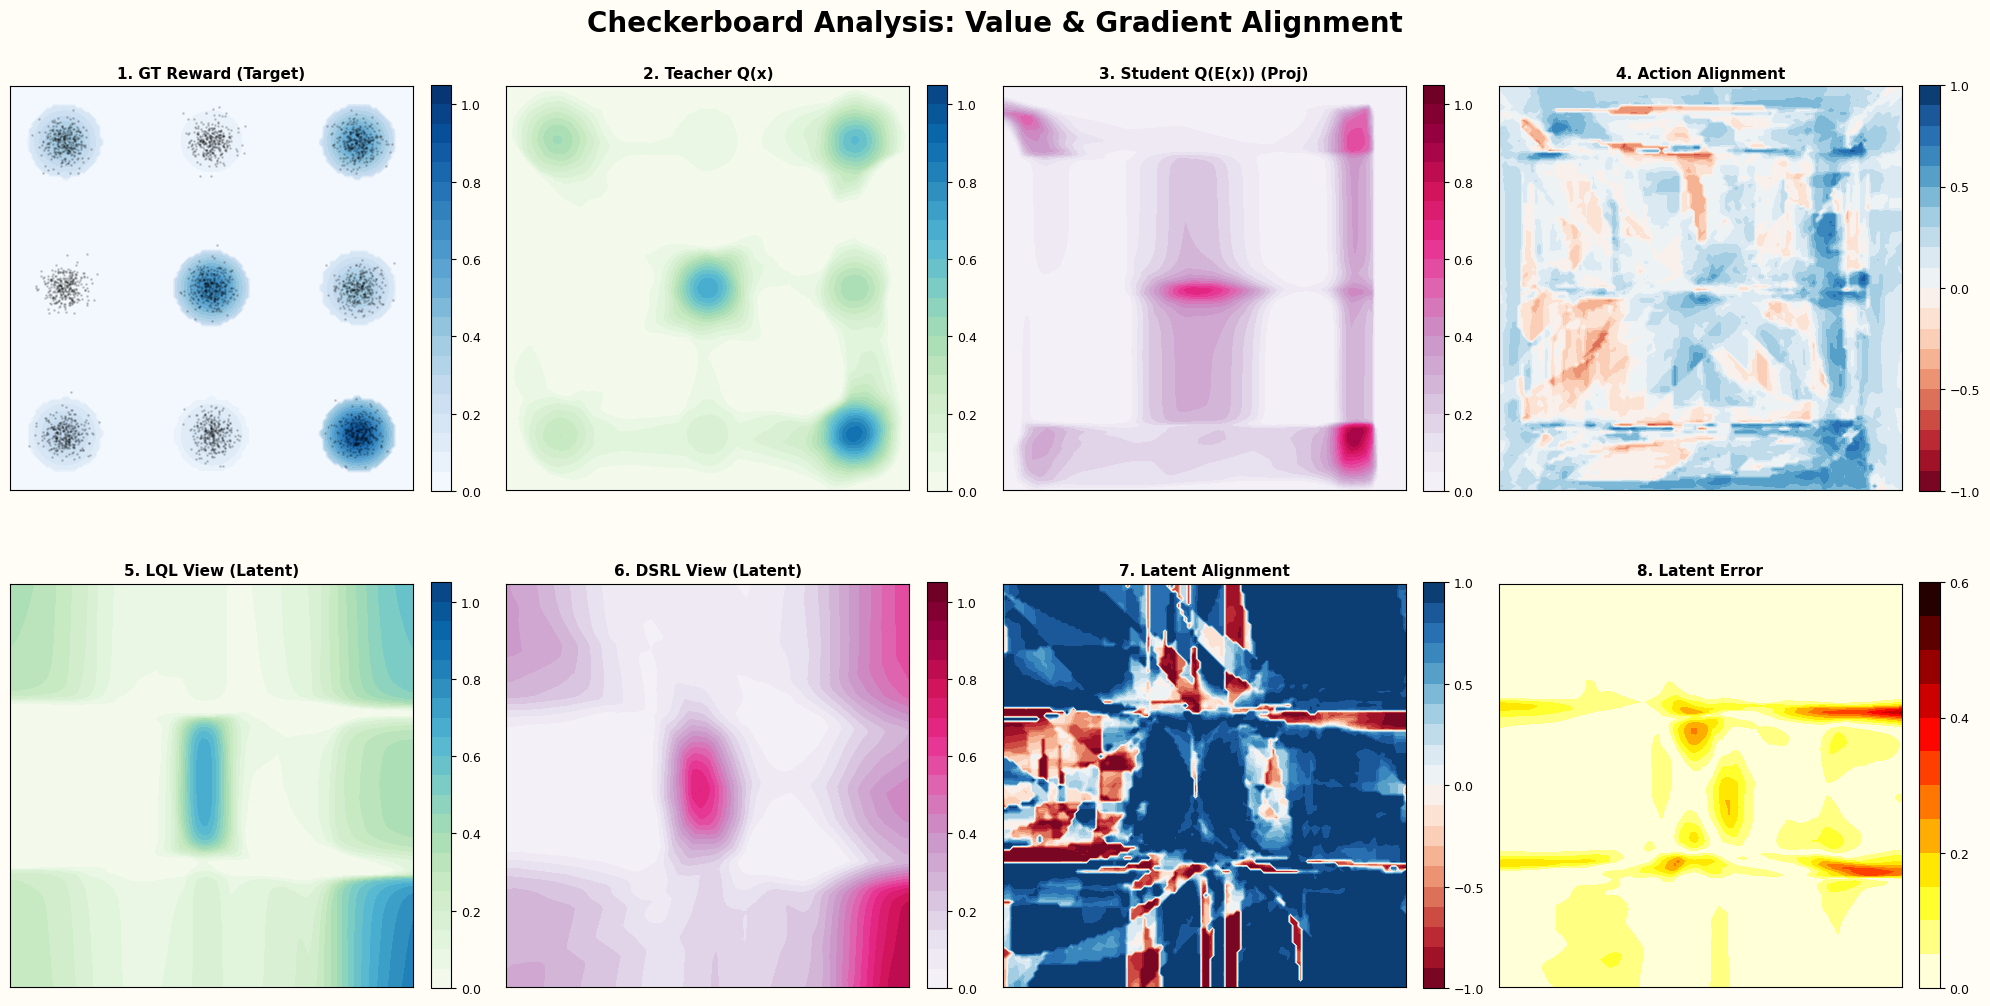

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'dim_high': 20,       
    'dim_latent': 20,     
    'n_samples': 3000,    # 데이터 충분히
    'batch_size': 128,     
    'epochs_flow': 2000,  
    'epochs_q': 1500,     
    'epochs_distill': 1500, 
    'lr': 1e-3,
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

# ==========================================
# 2. Checkerboard Generator (High Contrast)
# ==========================================
class ManifoldGenerator:
    def __init__(self, mode, dim_high, seed=42):
        self.mode = mode
        self.dim_high = dim_high
        self.rng = np.random.RandomState(seed)
        
        # Projection Matrix
        H = self.rng.randn(dim_high, 2)
        Q, _ = np.linalg.qr(H)
        self.P = torch.tensor(Q, dtype=torch.float32).to(CONFIG['device'])
        self.reproj = self.P.T
        
        # 3x3 Grid Centers
        grid_size = 3
        centers = np.linspace(-0.8, 0.8, grid_size)
        gx, gy = np.meshgrid(centers, centers)
        self.centers = np.vstack([gx.ravel(), gy.ravel()]).T # (9, 2)
        
        # ★ Diverse Rewards (High Contrast) ★
        # 인접한 칸끼리 값 차이를 크게 두어 Gradient를 급격하게 만듦
        # 0:Low, 1:High
        # Pattern:
        # H L H
        # L H L
        # H L H
        self.peak_values = np.array([
            0.3, 0.2, 0.9,
            0.0, 0.7, 0.4,
            0.4, 0.1, 0.6
        ])
        
        self.centers_tensor = torch.tensor(self.centers, dtype=torch.float32).to(CONFIG['device'])
        self.values_tensor = torch.tensor(self.peak_values, dtype=torch.float32).to(CONFIG['device'])

    def get_data(self, n):
        n_per_cluster = n // len(self.centers)
        data_list = []
        for center in self.centers:
            # Cluster Spread
            cluster_data = self.rng.randn(n_per_cluster, 2) * 0.06 + center
            data_list.append(cluster_data)
        data = np.vstack(data_list)
        self.rng.shuffle(data)
        return torch.tensor(data, dtype=torch.float32).to(CONFIG['device'])

    def lift(self, data_2d): return data_2d @ self.P.T

    def get_gt_reward(self, data_high):
        query_2d = data_high @ self.reproj.T
        # (N, 9, 2) - (1, 9, 2) broadcasting
        diff = query_2d.unsqueeze(1) - self.centers_tensor.unsqueeze(0)
        dist_sq = torch.sum(diff**2, dim=2) # (N, 9)
        
        # sigma=0.015: 봉우리를 아주 날카롭게 (High Frequency Signal)
        gaussian = torch.exp(-dist_sq / 0.04) 
        weighted_peaks = gaussian * self.values_tensor.unsqueeze(0)
        
        reward, _ = torch.max(weighted_peaks, dim=1)

        # [수정됨] Reward Masking (배경 노란색 제거)
        # 모든 센터로부터 일정 거리(radius) 이상 떨어진 곳은 Reward를 강제로 0으로 만듦
        # dist_sq > 0.04 (약 0.2 거리) 이면 0 처리
        mask = (dist_sq > 0.04).all(dim=1)
        reward[mask] = 0.0
        
        return reward.unsqueeze(1).float()

# ==========================================
# 3. Models & Training (Fair Comparison)
# ==========================================
class VectorField(nn.Module):
    def __init__(self, dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(dim + 1, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, dim))
    def forward(self, x, t):
        if isinstance(t, float) or t.ndim==0: t = torch.ones(x.shape[0], 1, device=x.device) * t
        return self.net(torch.cat([x, t], dim=1))

class FlowMatching(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.v_net = VectorField(dim)
    def ode_solve(self, x, reverse=False):
        steps = 20; dt = 1.0/steps * (-1 if reverse else 1)
        for i in range(steps):
            t = (1.0 if reverse else 0.0) + i * dt
            t_tensor = torch.ones(x.shape[0], 1, device=x.device) * t
            v = self.v_net(x, t_tensor); x = x + v * dt
        return x
    def encode(self, x): return self.ode_solve(x, reverse=True)
    def decode(self, z): return self.ode_solve(z, reverse=False)
    def compute_loss(self, x1):
        x0 = torch.randn_like(x1); t = torch.rand(x1.shape[0], 1, device=x1.device)
        xt = (1-t)*x0 + t*x1; ut = x1-x0
        return ((self.v_net(xt, t) - ut)**2).mean()

class MLP(nn.Module):
    # Both 128 Hidden Units
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, output_dim))
    def forward(self, x): return self.net(x)

def train_models():
    print(f"\n[CHECKERBOARD] Training (Equal Capacity: 128)...")
    gen = ManifoldGenerator('checkerboard', CONFIG['dim_high'])
    raw = gen.get_data(CONFIG['n_samples']); high = gen.lift(raw); rew = gen.get_gt_reward(high)
    loader = DataLoader(TensorDataset(high, rew), batch_size=CONFIG['batch_size'], shuffle=True)
    
    flow = FlowMatching(CONFIG['dim_high']).to(CONFIG['device'])
    teacher = MLP(CONFIG['dim_high'], 1, hidden_dim=128).to(CONFIG['device'])
    student = MLP(CONFIG['dim_latent'], 1, hidden_dim=128).to(CONFIG['device']) 
    
    opt_f = optim.Adam(flow.parameters(), lr=1e-3)
    opt_t = optim.Adam(teacher.parameters(), lr=1e-3)
    opt_s = optim.Adam(student.parameters(), lr=1e-3)
    
    print("1. Flow Training...")
    for _ in range(CONFIG['epochs_flow']):
        for x, _ in loader: opt_f.zero_grad(); flow.compute_loss(x).backward(); opt_f.step()
    print("2. Teacher Training...")
    for _ in range(CONFIG['epochs_q']):
        for x, r in loader: opt_t.zero_grad(); ((teacher(x)-r)**2).mean().backward(); opt_t.step()
    print("3. Distillation...")
    teacher.eval(); flow.eval()
    for _ in range(CONFIG['epochs_distill']):
        z = torch.randn(512, CONFIG['dim_latent'], device=CONFIG['device'])
        with torch.no_grad(): x_hat = flow.decode(z); target = teacher(x_hat)
        opt_s.zero_grad(); ((student(z) - target)**2).mean().backward(); opt_s.step()
        
    return gen, flow, teacher, student, raw

# ==========================================
# 4. Visualization: Dual Alignment Analysis
# ==========================================
def wash_data(data):
    if torch.is_tensor(data): return np.array(data.detach().cpu().tolist(), dtype=np.float64)
    return np.array(data, dtype=np.float64)

def visualize_dual_alignment(results):
    plt.style.use('default')
    bg_color = '#FFFDF5'
    gen, flow, teacher, student, raw = results
    
    # --- Grid Setup (Same) ---
    res = 120; lim = 1.1 
    gx = np.linspace(-lim, lim, res); gy = np.linspace(-lim, lim, res)
    xx, yy = np.meshgrid(gx, gy)
    grid_tensor = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32).to(CONFIG['device'])
    
    high_grid_action = gen.lift(grid_tensor) 
    z_plane_latent = gen.lift(grid_tensor)   
    
    # --- Gradient Calculation (Same) ---
    x_t = high_grid_action.clone().detach().requires_grad_(True)
    q_t = teacher(x_t)
    grad_t_action = torch.autograd.grad(q_t.sum(), x_t, create_graph=False)[0]
    
    x_s = high_grid_action.clone().detach().requires_grad_(True)
    z_s = flow.encode(x_s)
    q_s = student(z_s)
    grad_s_action = torch.autograd.grad(q_s.sum(), x_s, create_graph=False)[0]
    cos_sim_action = F.cosine_similarity(grad_t_action, grad_s_action, dim=1, eps=1e-8)
    
    z_l = z_plane_latent.clone().detach().requires_grad_(True)
    x_l = flow.decode(z_l)
    q_lql = teacher(x_l)
    grad_lql_latent = torch.autograd.grad(q_lql.sum(), z_l, create_graph=False)[0]
    
    q_dsrl = student(z_l)
    grad_dsrl_latent = torch.autograd.grad(q_dsrl.sum(), z_l, create_graph=False)[0]
    cos_sim_latent = F.cosine_similarity(grad_lql_latent, grad_dsrl_latent, dim=1, eps=1e-8)

    # --- Data Washing (Same) ---
    v_gt = wash_data(gen.get_gt_reward(high_grid_action)).reshape(res, res)
    v_teacher = wash_data(q_t).reshape(res, res)
    v_student_proj = wash_data(q_s).reshape(res, res)
    v_cos_action = wash_data(cos_sim_action).reshape(res, res)
    v_lql_latent = wash_data(q_lql).reshape(res, res)
    v_dsrl_latent = wash_data(q_dsrl).reshape(res, res)
    v_cos_latent = wash_data(cos_sim_latent).reshape(res, res)
    v_latent_error = np.abs(v_lql_latent - v_dsrl_latent)
    raw_np = wash_data(raw)

    # --- Plotting Helper (Improved) ---
    def plot_square(ax, data, title, cmap, levels, ticks, points=None):
        ax.set_aspect('equal')
        
        # [수정됨] 데이터 클리핑: extend를 끄기 위해 데이터를 levels 범위로 강제 조정
        # 이렇게 하면 'both'를 꺼도 흰색 빈 공간이 생기지 않음
        data_clipped = np.clip(data, levels[0], levels[-1])
        
        # [수정됨] extend='neither' 로 설정하여 컬러바 끝을 직사각형으로 만듦
        im = ax.contourf(xx, yy, data_clipped, levels=levels, cmap=cmap, 
                         vmin=levels[0], vmax=levels[-1], extend='neither')
        
        if points is not None:
            ax.scatter(points[:,0], points[:,1], c='k', s=1, alpha=0.15) # 투명도 조절
        ax.set_title(title, fontweight='bold', fontsize=11)
        ax.set_xticks([]); ax.set_yticks([])
        
        # Colorbar with specific ticks
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=ticks)
        cbar.ax.tick_params(labelsize=9)

    # --- Figure Setup ---
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    fig.patch.set_facecolor(bg_color)
    fig.suptitle("Checkerboard Analysis: Value & Gradient Alignment", fontsize=20, fontweight='bold', y=0.96)
    
    # Levels & Ticks Setup
    # Value: 0 ~ 1.0 (깔끔하게 0.1 단위)
    val_levels = np.linspace(0, 1.05, 22) # 0.05 단위로 촘촘하게
    val_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    # Cosine: -1 ~ 1
    cos_levels = np.linspace(-1, 1, 21)
    cos_ticks = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    # Error: 0 ~ 0.6
    err_levels = np.linspace(0, 0.6, 13)
    err_ticks = [0.0, 0.2, 0.4, 0.6]

    # === ROW 1: ACTION SPACE ===
    plot_square(axes[0, 0], v_gt, "1. GT Reward (Target)", 'Blues', val_levels, val_ticks, points=raw_np)
    plot_square(axes[0, 1], v_teacher, "2. Teacher Q(x)", 'GnBu', val_levels, val_ticks)
    plot_square(axes[0, 2], v_student_proj, "3. Student Q(E(x)) (Proj)", 'PuRd', val_levels, val_ticks)
    plot_square(axes[0, 3], v_cos_action, "4. Action Alignment", 'RdBu', cos_levels, cos_ticks)
    
    # === ROW 2: LATENT SPACE ===
    plot_square(axes[1, 0], v_lql_latent, "5. LQL View (Latent)", 'GnBu', val_levels, val_ticks)
    plot_square(axes[1, 1], v_dsrl_latent, "6. DSRL View (Latent)", 'PuRd', val_levels, val_ticks)
    plot_square(axes[1, 2], v_cos_latent, "7. Latent Alignment", 'RdBu', cos_levels, cos_ticks)
    plot_square(axes[1, 3], v_latent_error, "8. Latent Error", 'hot_r', err_levels, err_ticks)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    set_seed(42)
    results = train_models()
    visualize_dual_alignment(results)